# Problem 1: 10 Classifiers with logistic regression and MSE

## Import image data

In [1]:
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

(train_images_original, train_labels_original), (test_images_original, test_labels_original) = mnist.load_data()

Using TensorFlow backend.


## Preparing image data and hyperparameters

Problem 1 has been giving me trouble, not in its difficulty, but in tuning the hyperparameters. The batch size I have attempted to keep at 128 per the example we have studied in class, but the learning rate seems to need to go to relatively huge levels to get any decent accuracy. I have narrowed this issue down to the partial derivatives of the loss function, since in Problem 2 the results are far more reliable yet the only thing that changes is the loss.  But as the math is absurdly simple, and I have verified that it is correct, I can only assume that this problem is due to the fact that creating 10 classifiers with mean squared error is bound to produce mediocre results.  As seen in the graph of the individual loss for each classifier, while most of the classifiers show a convergence towards a minimum, some do not, thus ruining the accuracy as a whole.  In fact, to get any decent results, I need to set the learning rate fairly high and bring the batch size very small, basically performing standard stochastic gradient descent, but even then certain classifiers sometimes do not optimize.  That is the result I present in this run.  Even then, the model is highly volatile to the random starting weights and bias, and therefore may give either decent or bad results even when the hyperparameters stay the same.

In [0]:
train_images = train_images_original.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255

test_images = test_images_original.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

epochs = 10
batch_size = 10
lr = 0.8

## Function for converting labels to binary representation

This vectorized function takes each label in a list of labels, and, depending on the classifier being made, converts it to a binary label.  So if the classifier is for recognizing the number 2, then each label corresponding to 2 will be converted to 1 and all other labels are 0.

In [0]:
def convert_labels(old_label, new_label):
  return 1 if old_label == new_label else 0
convert_labels = np.vectorize(convert_labels)

## Logistic regression activation function

This function takes each element in a list of weighted inputs and passes it to the sigmoid.

In [0]:
def activation(z):
  return 1/(1 + np.exp(-z))

## Mean squared error loss function

This function takes the mean squared error between the activation result and the label.  The partial derivatives of this function seem to be what is causing this program to not function accurately, as Problem 2 is almost completely identical to this one, except for the loss.

In [0]:
def loss(a,y):
  base = a - y
  return 0.5 * np.power(base, 2)

## Classifier for each number

This classifier takes as input the number we will be training to classify.  It then converts all labels to binary representations for that number, and trains the network.  We do this for each number from 0 to 9. Each classifier returns the weights, bias, and list of loss values.

In [6]:
def classifier(num):
  # Convert labels to binary representation for number being trained.
  train_labels = convert_labels(train_labels_original, num)
  # Initialize random weights and bias.
  weights = np.random.randn(784)
  bias = np.random.randn()
  
  num_ims = len(train_images)
  
  # Average loss values across epochs
  loss_avgs = []
  
  for epoch in range(epochs):
    # Shuffle the training data on each epoch.
    shuffled_i = np.random.permutation(num_ims)
    X = train_images[shuffled_i]
    Y = train_labels[shuffled_i]
    
    # Calculate the average loss on each epoch.
    loss_epoch = 0.0
    for i in range(0, num_ims, batch_size):
        x = X[i:i+batch_size]
        y = Y[i:i+batch_size]
        
        # Take each training example in the batch and dot it with the
        # weights and then add the bias to get the weighted input.
        z = x.dot(weights) + bias
        # Pass the weighted input to the activation.
        a = activation(z)
        # Calculate the loss for all examples in batch and add it to loss for the epoch.
        loss_epoch += np.sum(loss(a, y))
        
        # Calculate the gradients with respect to the weights and bias
        # for each example.  For Problem 2, this is the only line of code
        # that changes in this function, as now we are using the partial derivatives 
        # of the binary cross-entropy loss.
        gradient_b = (a - y) * a *(1 - a)
        
        # We need to reshape so that the vectorized operation for the gradient
        # is done correctly.
        gradient_b = np.reshape(gradient_b, (len(gradient_b),1))
        gradient_w = x * gradient_b
       
        # Average the gradients across the batch and use the resulting value in the updates.
        gradient_b = np.mean(gradient_b)
        gradient_w = np.mean(gradient_w,axis=0)
        
        weights = weights - lr * gradient_w
        bias = bias - lr * gradient_b
    
    # Record the progress of the current classifier.
    print("Classifier %d: Epoch %d/%d.\tLoss: %f" % (num, epoch+1, epochs, loss_epoch/num_ims))
    # Add the average loss for the epoch to list of averages.
    loss_avgs.append(loss_epoch/num_ims)
  print()
  
  return (weights, bias, loss_avgs)

# Train a list of classifiers, one for each digit.
classif_list = [classifier(i) for i in range(10)]

Classifier 0: Epoch 1/10.	Loss: 0.020240
Classifier 0: Epoch 2/10.	Loss: 0.006583
Classifier 0: Epoch 3/10.	Loss: 0.005352
Classifier 0: Epoch 4/10.	Loss: 0.004816
Classifier 0: Epoch 5/10.	Loss: 0.004460
Classifier 0: Epoch 6/10.	Loss: 0.004245
Classifier 0: Epoch 7/10.	Loss: 0.004053
Classifier 0: Epoch 8/10.	Loss: 0.003939
Classifier 0: Epoch 9/10.	Loss: 0.003822
Classifier 0: Epoch 10/10.	Loss: 0.003669

Classifier 1: Epoch 1/10.	Loss: 0.010906
Classifier 1: Epoch 2/10.	Loss: 0.005138
Classifier 1: Epoch 3/10.	Loss: 0.004435
Classifier 1: Epoch 4/10.	Loss: 0.004105
Classifier 1: Epoch 5/10.	Loss: 0.003871
Classifier 1: Epoch 6/10.	Loss: 0.003751
Classifier 1: Epoch 7/10.	Loss: 0.003585
Classifier 1: Epoch 8/10.	Loss: 0.003520
Classifier 1: Epoch 9/10.	Loss: 0.003407
Classifier 1: Epoch 10/10.	Loss: 0.003311

Classifier 2: Epoch 1/10.	Loss: 0.022115
Classifier 2: Epoch 2/10.	Loss: 0.011737
Classifier 2: Epoch 3/10.	Loss: 0.010328
Classifier 2: Epoch 4/10.	Loss: 0.009661
Classifier 2

## Plotting average loss over epochs for each classifier

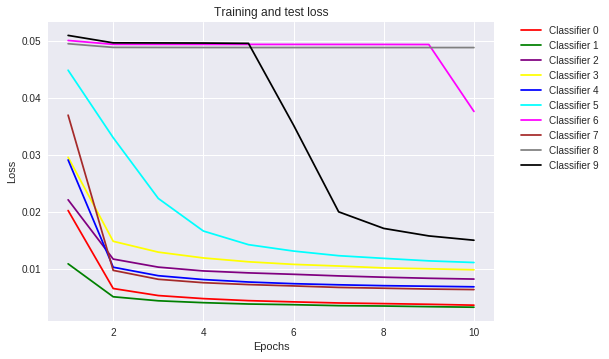

In [7]:
eps = range(1, epochs + 1)
colors = ['red', 'green', 'purple', 'yellow', 'blue', 'cyan', 'magenta', 'brown', 'gray', 'black']
for num in range(10):
  class_name = "Classifier %d" % num
  plt.plot(eps, classif_list[num][2], colors[num], label = class_name)

plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## Prediction function

This function takes a trained model for a classifier and a test example, and calculates the probability that the example is the number that the model is trained to recognize.

In [0]:
def predict(model, x):
  weights = model[0]
  bias = model[1]
  
  z = x.dot(weights) + bias
  return activation(z)

## Checking accuracy of each classifier

For each classifier, we pass it into a function that will determine how accurate the classifier is at recognizing its number by testing it on the entire test data set.

In [9]:
def single_classf_acc(num):
  num_true = 0
  
  # Convert all test labels to their binary form for the number
  # being recognized.
  test_labels = convert_labels(test_labels_original, num)
  
  for i in range(len(test_images)):
    xi = test_images[i]
    yi = test_labels[i]
    y_pred = predict(classif_list[num], xi)
    
    if y_pred>=0.5:
      y_pred = 1
    else:
      y_pred = 0

    if yi == y_pred:
      num_true+=1

  print("Classifier %d Accuracy: %f" % (num, num_true/len(test_images)))

print("Individual Accuracies of Classifiers:")
x = [single_classf_acc(i) for i in range(10)]

Individual Accuracies of Classifiers:
Classifier 0 Accuracy: 0.990800
Classifier 1 Accuracy: 0.992900
Classifier 2 Accuracy: 0.979100
Classifier 3 Accuracy: 0.979500
Classifier 4 Accuracy: 0.981300
Classifier 5 Accuracy: 0.977400
Classifier 6 Accuracy: 0.971700
Classifier 7 Accuracy: 0.984000
Classifier 8 Accuracy: 0.902600
Classifier 9 Accuracy: 0.964100


## Finding the accuracy of being able to recognize any number

Using the list of classifiers, pass the test data to them, and using argmax, determine which number each example is by choosing the classifier that "screams hardest".  Ouput how accurately the classifiers do this.

In [10]:
num_true = 0
for i in range(len(test_images)):
  xi = test_images[i]
  yi = test_labels_original[i]
  y_pred = np.argmax([predict(classif_list[j], xi) for j in range(10)])
  
  if yi == y_pred:
    num_true+=1
    
acc = num_true/len(test_images)
print("Overall Recognition Accuracy: %f" % acc)

Overall Recognition Accuracy: 0.831800
